In [1]:
import os
from glob import glob
from PIL import Image
import torch
import torchvision.transforms as transforms

IMAGE_SIZE = 64
BATCH_SIZE = 16

root_dir   = "C:/Users/hucu/Desktop/DeepLearningProject3/dataset/CatDataset/cats/Data"
exts       = ("jpg", "png", "jpeg")

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

paths = []
for e in exts:
    paths += glob(os.path.join(root_dir, f"*.{e}"))

print(f"Found {len(paths)} images in {root_dir}")

images = []
for p in paths:
    img = Image.open(p).convert("RGB")
    images.append(transform(img))

images = torch.stack(images)
print(f"Loaded images tensor with shape {images.shape}")


Found 29843 images in C:/Users/hucu/Desktop/DeepLearningProject3/dataset/CatDataset/cats/Data
Loaded images tensor with shape torch.Size([29843, 3, 64, 64])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_bn=True, activation='leaky'):
        super().__init__()
        act = nn.LeakyReLU(0.2, True) if activation=='leaky' else nn.ReLU(True)
        layers = [
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels) if use_bn else nn.Identity(),
            act,
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels) if use_bn else nn.Identity()
        ]
        self.block = nn.Sequential(*layers)
        self.act   = act

    def forward(self, x):
        return self.act(self.block(x) + x)

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()
        self.embedding_dim   = embedding_dim
        self.num_embeddings  = num_embeddings
        self.commitment_cost = commitment_cost
        self.embeddings      = nn.Embedding(num_embeddings, embedding_dim)
        nn.init.uniform_(self.embeddings.weight, -1/num_embeddings, 1/num_embeddings)

    def forward(self, inputs):
        B, C, H, W = inputs.shape
        flat = inputs.permute(0,2,3,1).reshape(-1, C)
        dists = (
            flat.pow(2).sum(1, keepdim=True)
            - 2 * flat @ self.embeddings.weight.t()
            + self.embeddings.weight.pow(2).sum(1)
        )
        idx     = torch.argmin(dists, dim=1)
        one_hot = F.one_hot(idx, self.num_embeddings).type(flat.dtype)
        quant   = (one_hot @ self.embeddings.weight).view(B, H, W, C).permute(0,3,1,2)
        # VQ losses:
        commit_loss = F.mse_loss(quant.detach(), inputs, reduction='mean')
        embed_loss  = F.mse_loss(quant, inputs.detach(), reduction='mean')
        vq_loss     = embed_loss + self.commitment_cost * commit_loss
        quant       = inputs + (quant - inputs).detach()
        return quant, vq_loss

def create_vqvae2(embedding_dim=64,
                  num_embeddings_bottom=512,
                  num_embeddings_top=512,
                  commitment_cost=0.25,
                  base_channels=64,
                  use_batchnorm=True,
                  activation='leaky',
                  num_res_blocks=2):
    
    Act = nn.LeakyReLU(0.2, True) if activation=='leaky' else nn.ReLU(True)

    # Bottom encoder (64→8)
    enc_b_layers = [
        nn.Conv2d(3, base_channels, 4,2,1),
        nn.BatchNorm2d(base_channels) if use_batchnorm else nn.Identity(), Act
    ] + [
        ResidualBlock(base_channels, use_batchnorm, activation)
        for _ in range(num_res_blocks)
    ] + [
        nn.Conv2d(base_channels, base_channels*2, 4,2,1),
        nn.BatchNorm2d(base_channels*2) if use_batchnorm else nn.Identity(), Act
    ] + [
        ResidualBlock(base_channels*2, use_batchnorm, activation)
        for _ in range(num_res_blocks)
    ] + [
        nn.Conv2d(base_channels*2, embedding_dim, 4,2,1)
    ]
    enc_b = nn.Sequential(*enc_b_layers)

    # Top encoder (8→4)
    enc_t = nn.Sequential(
        nn.Conv2d(embedding_dim, embedding_dim, 4,2,1),
        *[ResidualBlock(embedding_dim, use_batchnorm, activation)
          for _ in range(num_res_blocks)]
    )

    # Decoder (8→64)
    dec_layers = [
        nn.ConvTranspose2d(embedding_dim*2, base_channels*2, 4,2,1),
        nn.BatchNorm2d(base_channels*2) if use_batchnorm else nn.Identity(), Act
    ] + [
        ResidualBlock(base_channels*2, use_batchnorm, activation)
        for _ in range(num_res_blocks)
    ] + [
        nn.ConvTranspose2d(base_channels*2, base_channels, 4,2,1),
        nn.BatchNorm2d(base_channels) if use_batchnorm else nn.Identity(), Act
    ] + [
        ResidualBlock(base_channels, use_batchnorm, activation)
        for _ in range(num_res_blocks)
    ] + [
        nn.ConvTranspose2d(base_channels, 3, 4,2,1),
        nn.Tanh()
    ]
    dec = nn.Sequential(*dec_layers)

    class VQVAE2(nn.Module):
        def __init__(self):
            super().__init__()
            self.enc_b = enc_b
            self.vq_b  = VectorQuantizer(num_embeddings_bottom, embedding_dim, commitment_cost)
            self.enc_t = enc_t
            self.vq_t  = VectorQuantizer(num_embeddings_top,    embedding_dim, commitment_cost)
            self.dec   = dec

        def forward(self, x):
            z_b = self.enc_b(x)
            q_b, l_b = self.vq_b(z_b)
            z_t = self.enc_t(q_b)
            q_t, l_t = self.vq_t(z_t)
            q_t_up   = F.interpolate(q_t, scale_factor=2, mode='nearest')
            dec_in   = torch.cat([q_b, q_t_up], dim=1)
            x_recon  = self.dec(dec_in)
            return x_recon, l_b + l_t

    return VQVAE2()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_vqvae2().to(device)

In [ ]:
import gc
import optuna
import torch
import torch.nn.functional as F
from torch.optim import Adam, RMSprop, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler

N = images.size(0)
SUBSET = min(200, N)
subset_idx = torch.randperm(N)[:SUBSET]

def objective(trial):
    arch = {
        "embedding_dim":         trial.suggest_categorical("embedding_dim", [32,64,128]),
        "num_embeddings_bottom": trial.suggest_categorical("num_embeddings_bottom", [128,256]),
        "num_embeddings_top":    trial.suggest_categorical("num_embeddings_top",    [128,256]),
        "commitment_cost":       trial.suggest_float("commitment_cost",   0.1, 0.5),
        "base_channels":         trial.suggest_categorical("base_channels",   [32,64]),
        "use_batchnorm":         trial.suggest_categorical("use_batchnorm",   [True,False]),
        "activation":            trial.suggest_categorical("activation",      ["leaky","relu"]),
        "num_res_blocks":        trial.suggest_int("num_res_blocks", 1, 3)
    }
    opt_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop"])
    lr       = trial.suggest_float("lr", 1e-4, 1e-3, log=True)
    b1       = trial.suggest_float("beta1", 0.9, 0.999)
    b2       = trial.suggest_float("beta2", 0.99, 0.9999)
    wd       = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    m = create_vqvae2(**arch).to(device)
    if opt_name=="Adam":
        opt = Adam(m.parameters(), lr=lr, betas=(b1,b2), weight_decay=wd)
    else:
        opt = RMSprop(m.parameters(), lr=lr, weight_decay=wd)
    scaler = GradScaler()

    for _ in range(5):
        perms = torch.randperm(SUBSET)
        m.train()
        for i in range(0, SUBSET, BATCH_SIZE):
            batch = images[subset_idx[perms[i:i+BATCH_SIZE]]].to(device)
            opt.zero_grad()
            with autocast():
                rec, vq_l = m(batch)
                recon_l = F.mse_loss(rec, batch, reduction='mean')
                loss = recon_l + vq_l
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

    m.eval()
    total = 0.0
    with torch.no_grad():
        perms = torch.randperm(SUBSET)
        for i in range(0, SUBSET, BATCH_SIZE):
            batch = images[subset_idx[perms[i:i+BATCH_SIZE]]].to(device)
            rec, vq_l = m(batch)
            total += (F.mse_loss(rec, batch, reduction='mean') + vq_l).item()
    del m, opt, scaler
    torch.cuda.empty_cache(); gc.collect()
    return total / SUBSET

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
best = study.best_trial.params
print("Best hyperparameters:", best)

[I 2025-05-26 17:54:18,863] A new study created in memory with name: no-name-9cd33b02-827e-420b-9676-66f3a4e056cf
C:\Users\hucu\AppData\Local\Temp\ipykernel_34100\3448336245.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\hucu\AppData\Local\Temp\ipykernel_34100\3448336245.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[I 2025-05-26 17:54:21,152] Trial 0 finished with value: 0.04913982018828392 and parameters: {'embedding_dim': 32, 'num_embeddings_bottom': 256, 'num_embeddings_top': 128, 'commitment_cost': 0.4650824412392546, 'base_channels': 32, 'use_batchnorm': False, 'activation': 'leaky', 'num_res_blocks': 3, 'optimizer': 'RMSprop', 'lr': 0.00015102971706336337, 'beta1': 0.9644453932144591, 'beta2': 0.9996051701686153, 'weight_decay': 9.402104038477476e-05}. Best is

Best hyperparameters: {'embedding_dim': 32, 'num_embeddings_bottom': 256, 'num_embeddings_top': 256, 'commitment_cost': 0.32101008264975156, 'base_channels': 64, 'use_batchnorm': False, 'activation': 'relu', 'num_res_blocks': 3, 'optimizer': 'RMSprop', 'lr': 0.0002305634565157654, 'beta1': 0.9153663302638878, 'beta2': 0.9937780597125175, 'weight_decay': 1.8713899561699316e-05}


In [ ]:
import datetime, os
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
from torcheval.metrics import FrechetInceptionDistance
from tqdm import tqdm
from torchvision.utils import save_image

arch = {k: best[k] for k in [
    "embedding_dim","num_embeddings_bottom","num_embeddings_top",
    "commitment_cost","base_channels","use_batchnorm",
    "activation","num_res_blocks"
]}
opt_name = best["optimizer"]
lr, b1, b2 = best["lr"], best["beta1"], best["beta2"]
wd = best["weight_decay"]

model = create_vqvae2(**arch).to(device)
if opt_name=="Adam":
    optimizer = Adam(model.parameters(), lr=lr, betas=(b1,b2), weight_decay=wd)
else:
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=wd)
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
scaler = GradScaler()
fid_metric = FrechetInceptionDistance()

loss_history = []
fid_history = []
fid_epochs = []

run_dir = f"./vqvae2_run_{datetime.datetime.now():%Y%m%d_%H%M%S}"
os.makedirs(run_dir, exist_ok=True)

for epoch in range(1, 51):
    model.train(); perm = torch.randperm(N); ep_loss = 0.0
    for i in range(0, N, BATCH_SIZE):
        batch = images[perm[i:i+BATCH_SIZE]].to(device)
        optimizer.zero_grad()
        with autocast():
            rec, vq_l = model(batch)
            loss = F.mse_loss(rec, batch, reduction='mean') + vq_l
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        ep_loss += loss.item() * batch.size(0)
    scheduler.step()
    avg_loss = ep_loss / N
    loss_history.append(avg_loss)

    model.eval()
    with torch.no_grad():
        idx = torch.randperm(N)[:16]
        samples, _ = model(images[idx].to(device))
        save_image(samples.mul(0.5).add(0.5), f"{run_dir}/epoch_{epoch:02d}.png", nrow=4)

    if epoch % 10 == 0:
        with torch.no_grad():
            idx = torch.randperm(N)[:100]
            fake, _ = model(images[idx].to(device)); fake = fake.mul(0.5).add(0.5)
            real = images[idx].to(device).mul(0.5).add(0.5)
        fid_metric.reset()
        fid_metric.update(fake, is_real=False)
        fid_metric.update(real, is_real=True)
        fval = fid_metric.compute().item()
        fid_history.append(fval); fid_epochs.append(epoch)
        print(f"Epoch {epoch}/50 → Loss: {avg_loss:.4f}, FID@{epoch}: {fval:.2f}")
    else:
        print(f"Epoch {epoch}/50 → Loss: {avg_loss:.4f}")

C:\Users\hucu\AppData\Local\Temp\ipykernel_34100\604302766.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\hucu\AppData\Local\Temp\ipykernel_34100\604302766.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 → Loss: 1.1365
Epoch 2/50 → Loss: 0.0601
Epoch 3/50 → Loss: 0.0487
Epoch 4/50 → Loss: 0.0501
Epoch 5/50 → Loss: 0.0487
Epoch 6/50 → Loss: 0.0473
Epoch 7/50 → Loss: 0.0460
Epoch 8/50 → Loss: 0.0450
Epoch 9/50 → Loss: 0.0441
Epoch 10/50 → Loss: 0.0434, FID@10: 246.61
Epoch 11/50 → Loss: 0.0428
Epoch 12/50 → Loss: 0.0422
Epoch 13/50 → Loss: 0.0417
Epoch 14/50 → Loss: 0.0413
Epoch 15/50 → Loss: 0.0410
Epoch 16/50 → Loss: 0.0407
Epoch 17/50 → Loss: 0.0404
Epoch 18/50 → Loss: 0.0401
Epoch 19/50 → Loss: 0.0399
Epoch 20/50 → Loss: 0.0396, FID@20: 236.15
Epoch 21/50 → Loss: 0.0394
Epoch 22/50 → Loss: 0.0393
Epoch 23/50 → Loss: 0.0391
Epoch 24/50 → Loss: 0.0389
Epoch 25/50 → Loss: 0.0387
Epoch 26/50 → Loss: 0.0385
Epoch 27/50 → Loss: 0.0384
Epoch 28/50 → Loss: 0.0382
Epoch 29/50 → Loss: 0.0380
Epoch 30/50 → Loss: 0.0379, FID@30: 199.80
Epoch 31/50 → Loss: 0.0378
Epoch 32/50 → Loss: 0.0377
Epoch 33/50 → Loss: 0.0376
Epoch 34/50 → Loss: 0.0375
Epoch 35/50 → Loss: 0.0374
Epoch 36/50 → Lo

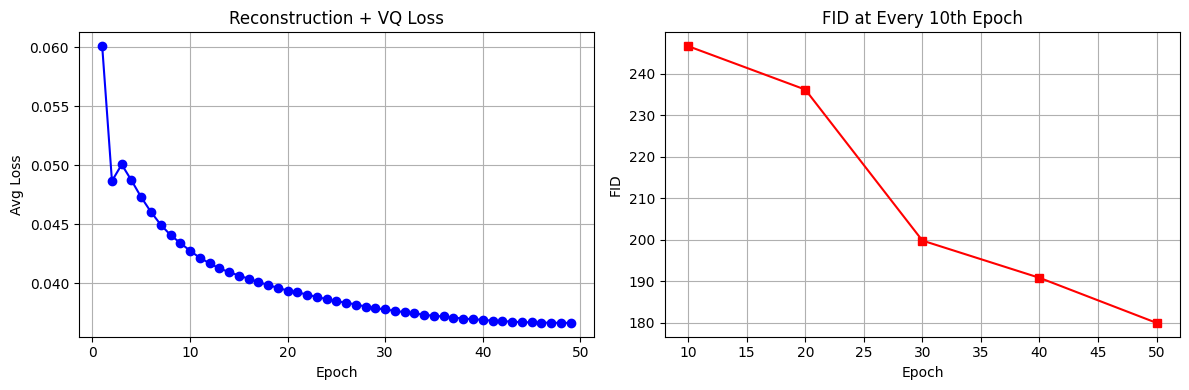

Final Loss: 0.0367
Final FID @50: 179.97


In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,50), loss_history[1:], 'b-o')
plt.title("Reconstruction + VQ Loss"); plt.xlabel("Epoch"); plt.ylabel("Avg Loss"); plt.grid()
plt.subplot(1,2,2)
plt.plot(fid_epochs, fid_history, 'r-s')
plt.title("FID at Every 10th Epoch"); plt.xlabel("Epoch"); plt.ylabel("FID"); plt.grid()
plt.tight_layout(); plt.show()

print(f"Final Loss: {loss_history[-1]:.4f}")
print(f"Final FID @{fid_epochs[-1]}: {fid_history[-1]:.2f}")

In [10]:
torch.save(model.state_dict(), "vqvae2_weights.pth")